##### This code has been developed for data exploration and preprocessing for Datathon Cajamar 2021, Spain. The task was to forecast sales for each of nearly 3000 stock items in each day during the 3-month-period folowing the dates of known sales.
##### The strategy selected by our team for the datathon was the following: to create time series models for each stock item using SARIMAX and Prophet metodologies, compare the errors produced by the models and choose the best methodology for further forecasting. 
##### The next step would be to create another model using the algorithm of Random Forest and compare the errors of predictions done by both models (RandomForest and one of the time series models) for the period of validation which would have the same length as the length of the test period, that is, three months.
##### The present notebook provides codes used for data exploration, preprocessing and models evaluation and selection.

In [1]:
# import necessary libraries
# importamos las librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX

pd.options.mode.chained_assignment = 'raise'

Importing plotly failed. Interactive plots will not work.


In [2]:
# stipulate a default formatting for graphs
# formato por defecto para los gráficos
from pylab import rcParams
rcParams['figure.figsize'] = 15,5

In [3]:
# read labeled and unlabeled datasets
# importamos los datos
data_train = pd.read_csv('Modelar_UH2021.txt', sep='|', decimal=",", low_memory=False)
data_test = pd.read_csv('Estimar2.txt', sep='|', decimal=",", low_memory=False)

## Data Train exploration and preprocessing

In [4]:
data_train.head()

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,1/6/2015 0:00:00,21972,0,C,75.0,No Rotura,NaN,0,0,5241.0,0
1,1/6/2015 0:00:00,23910,5,C,170.0,No Rotura,6.07,0,0,5241.0,3
2,1/6/2015 0:00:00,24306,13,A,46.0,No Rotura,NaN,0,0,NaN,0
3,1/6/2015 0:00:00,24306,13,A,46.0,No Rotura,NaN,0,0,NaN,0
4,1/6/2015 0:00:00,27144,15,E,230.0,No Rotura,NaN,0,0,4064.0,0


In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4045022 entries, 0 to 4045021
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   fecha              object 
 1   id                 int64  
 2   visitas            int64  
 3   categoria_uno      object 
 4   categoria_dos      float64
 5   estado             object 
 6   precio             float64
 7   dia_atipico        int64  
 8   campaña            int64  
 9   antiguedad         float64
 10  unidades_vendidas  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 339.5+ MB


In [6]:
# change dates data type to 'timestamps' 
# cambiamos formato de las fechas a "timestamp"
data_train['fecha']=pd.to_datetime(data_train['fecha'], format="%d/%m/%Y %H:%M:%S")
data_train['fecha'].dtype

dtype('<M8[ns]')

In [7]:
# check completeness
data_train.isnull().any()

fecha                False
id                   False
visitas              False
categoria_uno        False
categoria_dos         True
estado               False
precio                True
dia_atipico          False
campaña              False
antiguedad            True
unidades_vendidas    False
dtype: bool

In [8]:
# fill in for missing prices
data_train.precio.fillna(method='bfill', inplace=True)

# fill in for missing antiguedad
data_train.antiguedad.fillna(method='bfill', inplace=True)

# fill in for missing categoria_dos
data_train.categoria_dos.fillna(method='bfill', inplace=True)

In [9]:
data_train.isnull().any()

fecha                False
id                   False
visitas              False
categoria_uno        False
categoria_dos        False
estado               False
precio               False
dia_atipico          False
campaña              False
antiguedad           False
unidades_vendidas    False
dtype: bool

In [10]:
# change data type for "estado"
data_train.estado.unique()

array(['No Rotura', 'Rotura', 'Transito'], dtype=object)

In [11]:
# replace strings to values: 1-no rotura, 2-rotura, 3-transito
data_train.estado.replace({'No Rotura':1, 'Rotura':2, 'Transito':3}, inplace=True)
data_train['estado'].dtype

dtype('int64')

In [12]:
# El formato de fechas ahora es YYYY-MM-DD, asi que la primera fecha en el conjunto de modelar es 1 de junio, 2015  
# y la última el 30 de septiembre, 2016
data_train

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,2015-06-01,21972,0,C,75.0,1,6.07,0,0,5241.0,0
1,2015-06-01,23910,5,C,170.0,1,6.07,0,0,5241.0,3
2,2015-06-01,24306,13,A,46.0,1,6.12,0,0,4064.0,0
3,2015-06-01,24306,13,A,46.0,1,6.12,0,0,4064.0,0
4,2015-06-01,27144,15,E,230.0,1,6.12,0,0,4064.0,0
...,...,...,...,...,...,...,...,...,...,...,...
4045017,2016-09-30,457416,1395,F,336.0,1,50.38,0,0,130.0,9
4045018,2016-09-30,457422,1080,F,336.0,2,68.49,0,0,130.0,0
4045019,2016-09-30,458650,1385,K,340.0,1,68.49,0,0,126.0,0
4045020,2016-09-30,458660,1915,K,340.0,1,68.49,0,0,126.0,24


## 1. Time Series -> exploration and preprocessing

In [39]:
# select columns with data needed for further TIME SERIES analysis and modelling
# seleccionamos los campos que vamos a necesitar para analisis de series temporales
data = data_train.loc[:,['fecha','id','visitas','dia_atipico','campaña','precio','unidades_vendidas']]
data_t = data_test.loc[:,['fecha','id','visitas','dia_atipico','campaña','precio']]

In [40]:
# count for duplicates in train data set
# contamos duplicados en el conjunto de modelar
data.duplicated(keep='first').sum()

2006466

In [42]:
# count for duplicates in test data set
# buscamos duplicados en el conjunto de estimar
data_t.duplicated(keep='first').sum()

224

In [43]:
# eliminate duplicates
# eliminamos duplicados
data = data.drop_duplicates()
data_t = data_t.drop_duplicates()

# count unique registers in train data set 
# contamos registros únicos en el conjunto de modelar
print("Number of unique lines in the train dataset: "+ str(len(data)))

data.count()

Number of unique lines in the train dataset: 2038556


fecha                2038556
id                   2038556
visitas              2038556
dia_atipico          2038556
campaña              2038556
precio               2038556
unidades_vendidas    2038556
dtype: int64

In [44]:
# count unique registers in test data set
# contamos registros únicos en el conjunto de estimar
print("Number of unique lines in the test dataset: "+ str(len(data_t)))

data_t.count()

Number of unique lines in the test dataset: 218039


fecha          218039
id             218039
visitas        218039
dia_atipico    218039
campaña        218039
precio         218039
dtype: int64

In [45]:
# find out the number of unique stock codes in train data set
# averiguamos el número de articulos en el conjunto de modelar
print(" Number of stock codes in the train dataset: " + str(len(data['id'].unique())))

 Number of stock codes in the train dataset: 4168


In [46]:
# find out the number of unique stock codes in test data set
# averiguamos el número de articulos en el conjunto de estimar
print(" Number of stock codes in the test dataset: " + str(len(data_t['id'].unique())))

 Number of stock codes in the test dataset: 2894


In [47]:
# since a time series should have only one observation for each day, check for duplicated dates for each stock code
# buscamos los articulos que tengan registros multiples para alguna fecha 

duplicates = []

for each in data_t['id'].unique():
    df = data[data['id']==each]
    if not df['fecha'].is_unique:
        duplicates.append(each)

len(duplicates)    

777

In [48]:
# collect all lines with duplicated dates in one dataframe for further investigation
# Juntamos los registros con fechas duplicadas en una tabla para entender mejor que pasa 
err_entries = pd.DataFrame()

for each in duplicates:
    
    df = data[data['id']==each].copy()
    fechas_dup = pd.Series(df['fecha'])[pd.Series(df['fecha']).duplicated()].values  
    
    for fecha in fechas_dup:
        df1 = df[df['fecha']==fecha].copy()
        err_entries = pd.concat([err_entries, df1])             

err_entries

,fecha,id,visitas,dia_atipico,campaña,precio,unidades_vendidas
1428652,2015-11-20,44990,71,1,0,28.71,3
1428655,2015-11-20,44990,71,1,1,28.71,3
1436958,2015-11-21,44990,209,1,0,26.67,27
1436961,2015-11-21,44990,209,1,1,26.67,27
1445264,2015-11-22,44990,76,1,0,26.67,21
...,...,...,...,...,...,...,...
3322351,2016-07-05,435980,3850,1,0,76.42,30
3330656,2016-07-06,435980,2140,1,1,76.42,15
3330657,2016-07-06,435980,2140,1,0,76.42,15
3338962,2016-07-07,435980,2050,1,0,76.42,9


In [45]:
# The duplicates have all fields but 'campaña' the same, the lines with 'campaña'=0 are to be deleted

# DUPLICATES!! por la culpa del campo 'campaña'
# es logico quitar la linea donde campaña=0 - la cantidad vendida es alta, más probable que son ventas de promocion

# por ejemplo:
err_entries[err_entries['id']==327526]

,fecha,id,visitas,dia_atipico,campaña,precio,unidades_vendidas
1426220,2015-11-19,327526,2725,1,0,18.37,339
1426223,2015-11-19,327526,2725,1,1,18.37,339
1434526,2015-11-20,327526,7500,1,1,17.88,2031
1434527,2015-11-20,327526,7500,1,0,17.88,2031
1442832,2015-11-21,327526,3378,1,1,17.92,717
1442833,2015-11-21,327526,3378,1,0,17.92,717
1451138,2015-11-22,327526,3090,1,0,17.94,633
1451141,2015-11-22,327526,3090,1,1,17.94,633
1459444,2015-11-23,327526,3443,1,1,17.96,984
1459445,2015-11-23,327526,3443,1,0,17.96,984


In [46]:
# create a time series dataframe for the stock code=327526
# creamos una dataframe para el articulo 327526

df_ = pd.DataFrame(index=pd.date_range('2015-06-01', periods=488, freq='D'))

df = data[data['id']==327526].copy()
df.loc[:,'delete'] = 0


# señalamos duplicados para eliminar
fechas_dup = pd.Series(df['fecha'])[pd.Series(df['fecha']).duplicated()].values  
    
for fecha in fechas_dup:
    index = df[(df['fecha'] ==fecha ) & (df['campaña']==0)].index
    df.loc[index, 'delete']=1

            
# eliminamos duplicados
index_names = df[df['delete'] == 1 ].index 
df.drop(index_names, inplace = True)


# cambiamos el indice
df.index=df['fecha']
df.index = pd.to_datetime(df.index)


# si es un dia de campaña, ponemos a cero el campo "dia_atipico" para tenerlos independientes
for i in range(len(df)):
    if (df.loc[df.index[i],'campaña']==1):
        df.loc[df.index[i],['dia_atipico']]=0 
        
# si es un dia sin ventas, ponemos a cero el campo "precio" 
for i in range(len(df)):
    if (df.loc[df.index[i],'unidades_vendidas']==0):
        df.loc[df.index[i],['precio']]=0         
        
        
# selecionamos los campos que vamos a utulizar
df = pd.DataFrame(df[['unidades_vendidas','visitas','campaña','dia_atipico','precio']])
      
        
# añadimos los datos al dataframe con indices correctos
ts = pd.concat([df_,df], axis=1)
ts.fillna(value=0, inplace=True)
ts

,unidades_vendidas,visitas,campaña,dia_atipico,precio
2015-06-01,0.0,0.0,0.0,0.0,0.00
2015-06-02,0.0,0.0,0.0,0.0,0.00
2015-06-03,0.0,0.0,0.0,0.0,0.00
2015-06-04,0.0,0.0,0.0,0.0,0.00
2015-06-05,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...
2016-09-26,6.0,565.0,0.0,0.0,17.88
2016-09-27,0.0,280.0,0.0,0.0,0.00
2016-09-28,0.0,205.0,0.0,0.0,0.00
2016-09-29,0.0,295.0,0.0,0.0,0.00


In [47]:
# days of promotion
# las fechas de promocion -> los campos de campaña =1, los de dia atipico =0
ts[ts['campaña']!=0]

,unidades_vendidas,visitas,campaña,dia_atipico,precio
2015-11-19,339.0,2725.0,1.0,0.0,18.37
2015-11-20,2031.0,7500.0,1.0,0.0,17.88
2015-11-21,717.0,3378.0,1.0,0.0,17.92
2015-11-22,633.0,3090.0,1.0,0.0,17.94
2015-11-23,984.0,3443.0,1.0,0.0,17.96
2015-11-24,324.0,1369.0,1.0,0.0,17.88
2015-11-25,273.0,1503.0,1.0,0.0,18.28
2015-11-26,876.0,3113.0,1.0,0.0,17.88
2016-07-01,165.0,4770.0,1.0,0.0,17.72
2016-07-02,324.0,12750.0,1.0,0.0,17.22


In [48]:
# check for uniqueness of dates
# no hay registros multiples para la misma fecha
ts.index.is_unique

True

## 2. Time series analysis and modeling

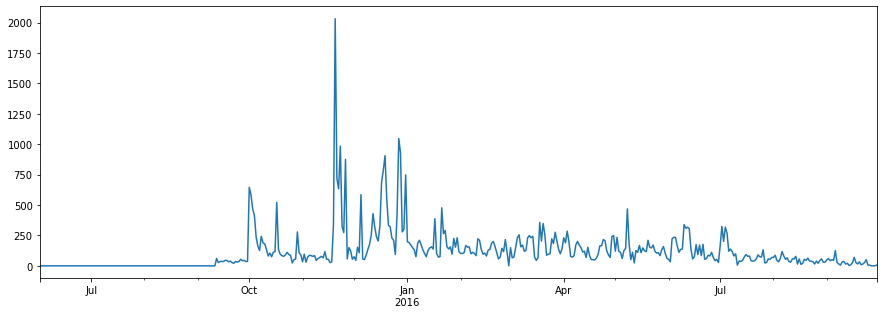

In [49]:
# plot the time series for stock code 327526
# visualizamos la serie pa el articulo 327526
ts['unidades_vendidas'].plot()

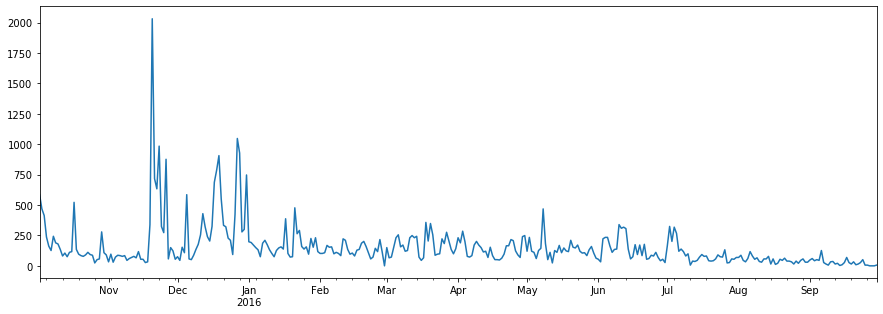

In [50]:
# limit the series to the last year of observations
# limitamos la serie para no incluir los valores muy antiguos
ts=ts.iloc[-365:,:].copy()
ts['unidades_vendidas'].plot()

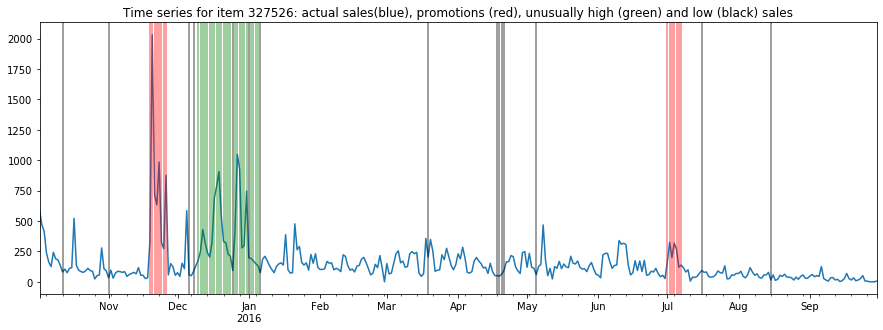

In [55]:
# plot the series indicating days of promotion and unusual sales
# visualizamos con dias atipicos y dias de campañas:
ax = ts['unidades_vendidas'].plot(title="Time series for item 327526: actual sales(blue), promotions (red), unusually high (green) and low (black) sales")
  
for day in ts[ts['campaña']==1].index:
              ax.axvline(x=day, color='red', alpha=0.5)  

for day in ts[ts['dia_atipico']==1].index:
              ax.axvline(x=day, color='green', alpha=0.5)  
        
for day in ts[ts['dia_atipico']==-1].index:
              ax.axvline(x=day, color='black', alpha=0.5)  

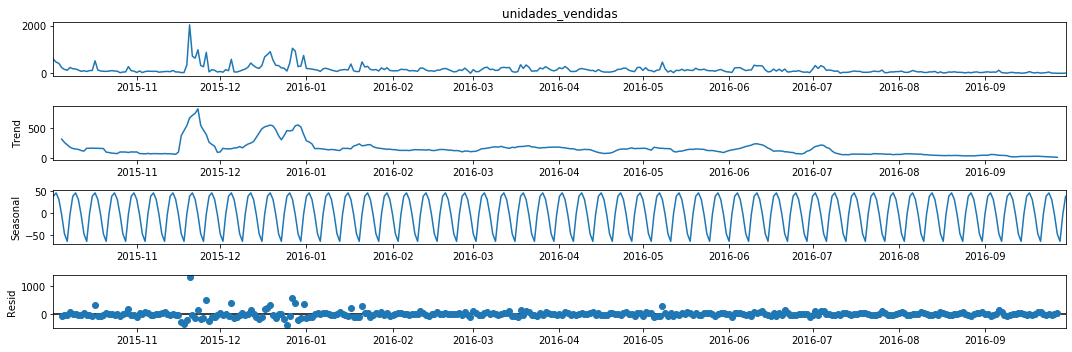

In [27]:
# descompose the series
# descomponemos la serie
ts_dec = seasonal_decompose(ts['unidades_vendidas'])
ts_dec.plot();

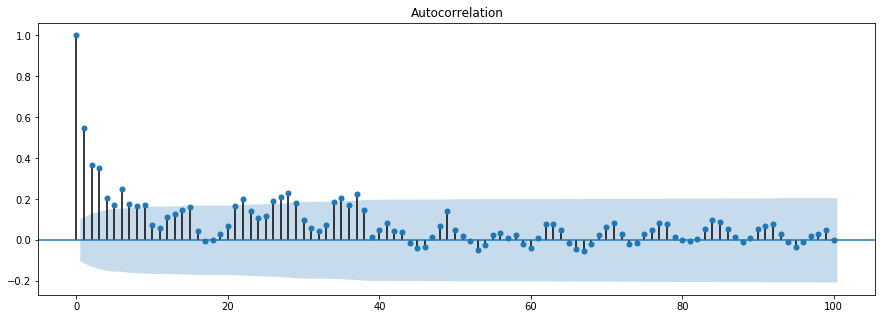

In [28]:
# check for autocorrelation in the series
# un chequeo de autocorrelación entre valores en la serie
plot_acf(ts['unidades_vendidas'], lags=100);

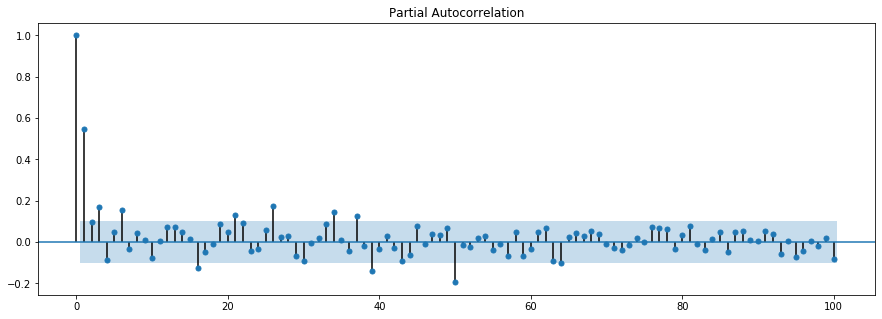

In [29]:
plot_pacf(ts['unidades_vendidas'], lags=100);

In [30]:
# check for stationarity -> the series is stationary
# un chequeo de estacionariedad -> la serie es estacionaria
adfuller(ts['unidades_vendidas'])

(-4.687448611016417,
 8.884213505152e-05,
 5,
 359,
 {'1%': -3.4486972813047574,
  '5%': -2.8696246923288418,
  '10%': -2.571077032068342},
 4460.758212522094)

#### Modeling with SARIMAX

In [31]:
# looking for the best model with two exogenous variables for the series making use of autoarima module
# buscamos el mejor modelo con dos campos adicionales de forma automatica 
res = auto_arima(ts['unidades_vendidas'],exogenous=ts[['campaña','dia_atipico']], m=7, trace=True, suppress_warnings=True,
                enforce_invertibility=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.24 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=4764.061, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=4722.428, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=4657.134, Time=1.25 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=4762.094, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=4654.362, Time=0.59 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=4656.538, Time=1.10 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=4645.766, Time=1.82 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=4638.997, Time=2.14 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=4657.363, Time=1.80 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=4637.330, Time=2.92 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=4637.930, Time=2.56 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.62 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=2.99 sec
 ARIMA(0,1,2)(2,0,2)[7] intercept   : AIC=inf, T

In [32]:
order =res.order
seasonal_order =res.seasonal_order

In [33]:
# the best model's parameters
# los parametros del modelo encontrado
sar = SARIMAX(ts['unidades_vendidas'], 
          exogenous=ts[['campaña','dia_atipico']],    
                                order=order,
             seasonal_order = seasonal_order).fit()
sar.summary()

C:\Users\Tanya\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                 unidades_vendidas   No. Observations:                  365
Model:             SARIMAX(0, 1, 2)x(2, 0, 2, 7)   Log Likelihood               -2342.566
Date:                           Wed, 03 Mar 2021   AIC                           4699.133
Time:                                   23:04:18   BIC                           4726.413
Sample:                               10-02-2015   HQIC                          4709.975
                                    - 09-30-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4925      0.029    -16.789      0.000      -0.550      -0.435
ma.L2         -0.3323      0.032    -10.534      0.000      -0.394      -0.270
ar.S.L7        0.1081      0.107      1.012      0.312      -0.101       0.318
ar.S.L14      -0.9346      0.113     -8.274      0.000      -1.156      -0.713
ma.S.L7       -0.1461      0.115     -1.268      0.205      -0.372       0.080
ma.S.L14       0.8999      0.147      6.141      0.000       0.613       1.187
sigma2      2.299e+04    622.610     36.919      0.000    2.18e+04    2.42e+04
===================================================================================
Ljung-Box (Q):                       87.68   Jarque-Bera (JB):             54915.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                             5.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        62.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

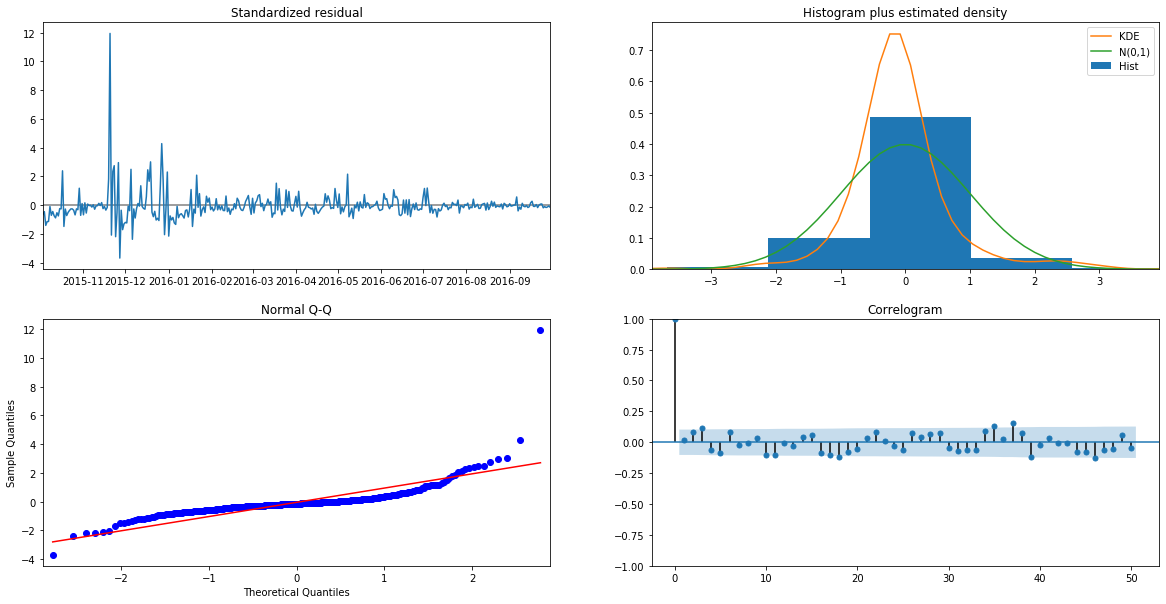

In [34]:
# plot residual diagnostics
# visualizamos los residuos para comprobar que son bastante aleatorios
resid = sar.resid[sar.loglikelihood_burn:];
sar.plot_diagnostics(lags=50,figsize = (20,10),);

In [56]:
# divide train data set in train and validation sets
# dividimos los datos en conjuntos de entrenamiento y de validación
train = ts[:-90]
test = ts[-90:]

In [57]:
# fit the model using train set
# ajustamos el modelo utilizando el conjunto de entrenamiento
sar = SARIMAX(train['unidades_vendidas'], 
              exogenous=ts[['campaña','dia_atipico']],
                                order=order,
             seasonal_order=seasonal_order.fit()
sar.summary()

C:\Users\Tanya\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                 unidades_vendidas   No. Observations:                  275
Model:             SARIMAX(0, 1, 2)x(2, 0, 2, 7)   Log Likelihood               -1800.345
Date:                           Wed, 10 Mar 2021   AIC                           3614.690
Time:                                   19:40:21   BIC                           3639.982
Sample:                               10-02-2015   HQIC                          3624.841
                                    - 07-02-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4888      0.038    -12.968      0.000      -0.563      -0.415
ma.L2         -0.3309      0.041     -8.104      0.000      -0.411      -0.251
ar.S.L7        0.1076      0.103      1.048      0.295      -0.094       0.309
ar.S.L14      -0.9864      0.111     -8.865      0.000      -1.204      -0.768
ma.S.L7       -0.1331      0.118     -1.124      0.261      -0.365       0.099
ma.S.L14       0.9689      0.249      3.888      0.000       0.480       1.457
sigma2      2.945e+04   3604.203      8.170      0.000    2.24e+04    3.65e+04
===================================================================================
Ljung-Box (Q):                       68.28   Jarque-Bera (JB):             23967.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                             4.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        47.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

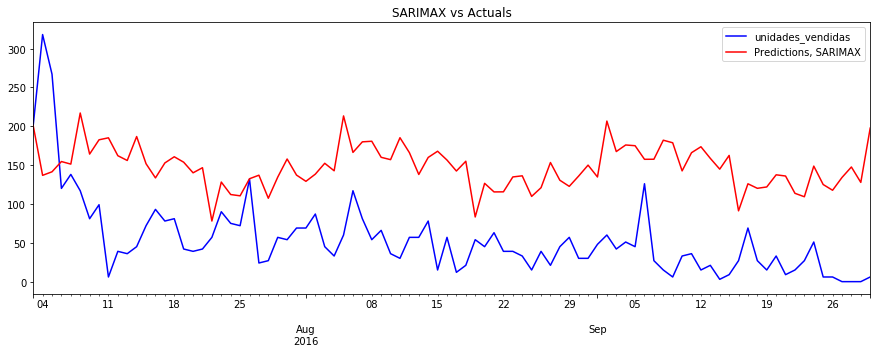

In [68]:
# make and plot predictions for validation dataset 
# calculamos y visualizamos las predicciones para el conjunto de validación

start=len(train)
end=len(train)+len(test)-1

predictions = sar.predict(start=start, end=end).rename('Predictions, SARIMAX')
test['unidades_vendidas'].plot(legend=True, c='blue')
predictions.plot(legend=True, title="SARIMAX vs Actuals", c='red');

In [38]:
# calculate the error for prediction
# calculamos el error de prediccion
mean_absolute_error(test['unidades_vendidas'], predictions)

100.05261285544455

In [39]:
# looking for the best model with three exogenous variables for the series making use of autoarima module
# buscamos el mejor modelo con tres campos adicionales de forma automatica 
res = auto_arima(ts['unidades_vendidas'], exogenous=ts[['campaña','dia_atipico','visitas']], m=7, trace=True, 
                 suppress_warnings=True, enforce_invertibility=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=4634.453, Time=2.19 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=4756.505, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=4713.906, Time=0.74 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=4649.560, Time=1.52 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=4754.536, Time=0.40 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=4632.009, Time=2.13 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=4634.540, Time=3.64 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=4631.412, Time=3.15 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=3.32 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=4636.409, Time=3.63 sec
 ARIMA(1,1,2)(1,0,0)[7] intercept   : AIC=4631.940, Time=1.11 sec
 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=4633.321, Time=1.84 sec
 ARIMA(3,1,2)(1,0,0)[7] intercept   : AIC=4627.660, Time=2.35 sec
 ARIMA(3,1,2)(0,0,0)[7] intercept   : AIC=i

In [40]:
# the best model's parameters
# los parametros del modelo encontrado
order =res.order
seasonal_order =res.seasonal_order

sar = SARIMAX(ts['unidades_vendidas'], 
          exogenous=ts[['campaña','dia_atipico', 'visitas']],    
                                order=order,
             seasonal_order = seasonal_order).fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      unidades_vendidas   No. Observations:                  365
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -2331.710
Date:                Wed, 03 Mar 2021   AIC                           4677.421
Time:                        23:06:08   BIC                           4704.701
Sample:                    10-02-2015   HQIC                          4688.263
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2796      0.120     -2.339      0.019      -0.514      -0.045
ar.L2         -0.3015      0.083     -3.648      0.000      -0.463      -0.140
ar.L3          0.4772      0.043     11.184      0.000       0.394       0.561
ma.L1         -0.2188      0.130     -1.683      0.092      -0.474       0.036
ma.L2         -0.0740      0.130     -0.568      0.570      -0.330       0.181
ma.L3         -0.6441      0.085     -7.554      0.000      -0.811      -0.477
sigma2      2.135e+04    423.875     50.365      0.000    2.05e+04    2.22e+04
===================================================================================
Ljung-Box (Q):                       71.13   Jarque-Bera (JB):             68092.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                             5.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        68.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

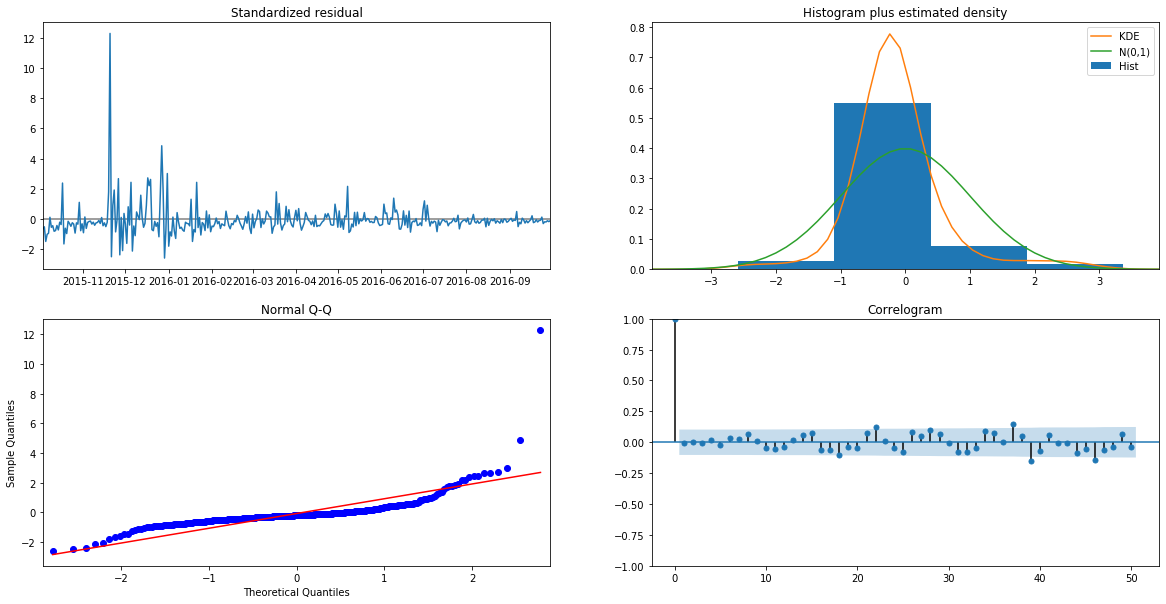

In [41]:
# plot residual diagnostics
# visualizamos los residuos para comprobar que son bastante aleatorios
resid = sar.resid[sar.loglikelihood_burn:];
sar.plot_diagnostics(lags=50,figsize = (20,10),);

In [42]:
# fit the model using train set
# ajustamos el modelo utilizando el conjunto de entrenamiento
sar = SARIMAX(train['unidades_vendidas'], 
              exogenous=ts[['campaña','dia_atipico', 'visitas']],
                                order=order,
             seasonal_order=seasonal_order).fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      unidades_vendidas   No. Observations:                  275
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -1791.910
Date:                Wed, 03 Mar 2021   AIC                           3597.820
Time:                        23:06:10   BIC                           3623.112
Sample:                    10-02-2015   HQIC                          3607.971
                         - 07-02-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2743      0.153     -1.790      0.073      -0.575       0.026
ar.L2         -0.2982      0.108     -2.751      0.006      -0.511      -0.086
ar.L3          0.4823      0.054      8.892      0.000       0.376       0.589
ma.L1         -0.2282      0.168     -1.358      0.175      -0.558       0.101
ma.L2         -0.0824      0.171     -0.481      0.631      -0.418       0.253
ma.L3         -0.6519      0.112     -5.819      0.000      -0.871      -0.432
sigma2      2.782e+04    752.821     36.952      0.000    2.63e+04    2.93e+04
===================================================================================
Ljung-Box (Q):                       55.00   Jarque-Bera (JB):             29665.86
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                             5.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        52.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

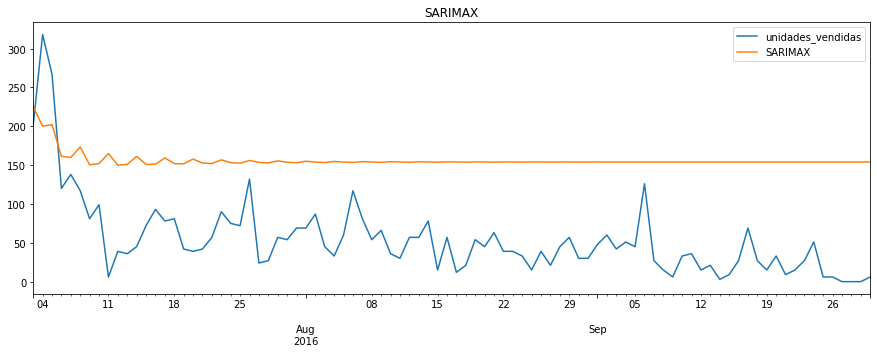

In [43]:
# make and plot predictions for validation dataset 
# calculamos y visualizamos las predicciones para el conjunto de validación

predictions = sar.predict(start=start, end=end).rename('SARIMAX')
test['unidades_vendidas'].plot(legend=True)
predictions.plot(legend=True, title="SARIMAX");

In [44]:
# calculate the error for prediction
# calculamos el error de prediccion
mean_absolute_error(test['unidades_vendidas'], predictions)

105.9844348740667

### Modeling with Prophet

In [59]:
# add columns required by Prophet library
# añadimos los campos requeridos por Prophet

ts['ds']=ts.index
ts['y']=ts.loc[:,'unidades_vendidas']

# update train and validation sets
# actualizamos los datos de entrenamiento y validacion
train = ts[:-90]
test = ts[-90:]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Tanya\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


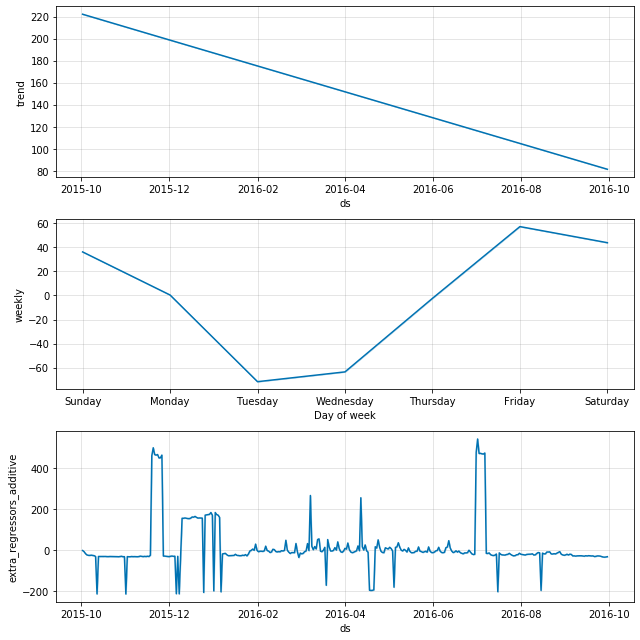

In [60]:
# make a model with two additional regressors, plot the time series components
# creamos el modelo con dos regresores adicionales, visualizamos los componentes de la serie
m = Prophet(changepoint_prior_scale=0.05)
m.add_regressor('campaña')
m.add_regressor('dia_atipico')
m.add_regressor('visitas')
m.fit(train)

future = m.make_future_dataframe(periods=len(test), freq='D')
future['campaña']=ts['campaña'].to_list()
future['dia_atipico']=ts['dia_atipico'].to_list()
future['visitas']=ts['visitas'].to_list()

forecast = m.predict(future)
fig = m.plot_components(forecast)

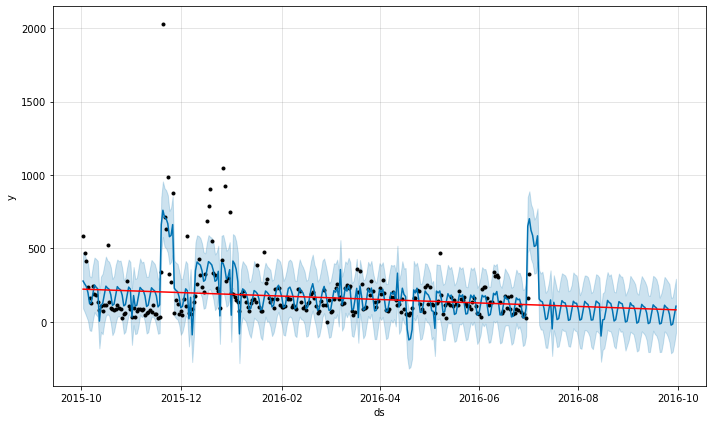

In [61]:
# plot the series calculated by the model together with confidence intervals and tendency line
# visualizamos la serie reproducida por el modelo junto con los intervalos de confianza y lineas del cambio en tendencia
fig = m.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [62]:
# change negative predicted values to zeros
# cambiamos los valores negativos en la prediccion a ceros
predictions = forecast.iloc[-90:][['ds','yhat']]
predictions['yhat']=predictions['yhat'].astype(int)

for i in range(len(predictions)):
    if predictions.iloc[i,1] < 0:
        predictions.iloc[i,1] = 0

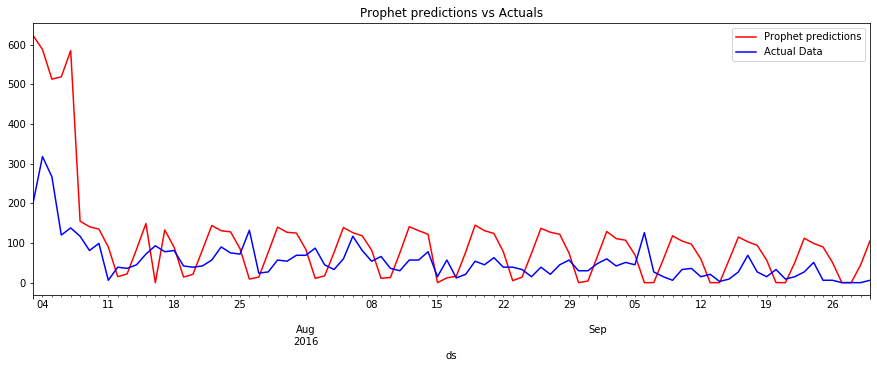

In [67]:
# plot the series in the validation period: predictions vs actuals
# visualizamos la predicción y los datos actuales en el periodo de validación
ax = predictions.plot(x='ds',y='yhat', label='Prophet predictions', legend=True, c='red')
test.plot(x='ds',y='y', title='Prophet predictions vs Actuals',xlim=xlim, label='Actual Data', c='blue',legend=True, ax=ax);

In [57]:
# calculate the prediction error
# calculamos el error del modelo

mean_absolute_error(test['y'], predictions['yhat'])

66.67777777777778

In [58]:
# It seems that Prophet gives a better model than SARIMAX since the error is lower
# Parece que Prophet produce un mejor modelo que SARIMAX por ser el error mas bajo

## 3. Test data set -> exploration and preprocessing

In [33]:
data_test.head()

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad
0,2016-10-01,21972,5,C,75,No Rotura,5.84,0,0,5150
1,2016-10-02,21972,15,C,75,No Rotura,5.84,0,0,5150
2,2016-10-03,21972,5,C,75,No Rotura,5.84,0,0,5150
3,2016-10-04,21972,5,C,75,No Rotura,5.84,0,0,5150
4,2016-10-05,21972,0,C,75,No Rotura,5.84,0,0,5150


In [34]:
# check for completeness y data types
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212841 entries, 0 to 212840
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   fecha          212841 non-null  object 
 1   id             212841 non-null  int64  
 2   visitas        212841 non-null  int64  
 3   categoria_uno  212841 non-null  object 
 4   categoria_dos  212841 non-null  object 
 5   estado         212841 non-null  object 
 6   precio         212841 non-null  float64
 7   dia_atipico    212841 non-null  int64  
 8   campaña        212841 non-null  int64  
 9   antiguedad     212841 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 16.2+ MB


In [36]:
# check for duplicates
data_test.iloc[np.where(data_test.duplicated())]

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad


In [37]:
# estado data type
data_test.estado.unique()

array(['No Rotura', 'Transito'], dtype=object)

In [38]:
# replace strings to values: 1-no rotura, 2-rotura, 3-transito
data_test.estado.replace({'No Rotura':1, 'Transito':3}, inplace=True)
data_test['estado'].dtype

dtype('int64')

In [39]:
data_test.categoria_dos.unique()

array(['75', '170', '230', '157', '63', '76', '224', '66', '263', '65',
       '312', '72', '34', '103', '155', '92', '160', '73', '161', '192',
       '271', '69', '338', '29', '123', '298', '304', '235', '158', '16',
       '286', '137', '43', '127', '270', '46', '20', '343', '266', '197',
       '319', '2', '236', '223', '145', '97', '39', '207', '228', '10',
       '292', '42', '7', '253', '85', '82', '305', '326', '179', '23',
       '295', '255', '188', '143', '37', '28', '86', '276', '30', '93',
       '105', '303', '221', '57', '323', '282', '259', '202', '150',
       '144', '247', '233', '78', '109', '49', '315', '67', '206', '135',
       '258', '238', '264', '316', '8', '237', '277', '80', '38', '201',
       '296', '120', '195', '156', '51', '14', '131', '200', '267', '5',
       '186', '245', '50', '285', '44', '136', '116', '45', '108', '243',
       '95', '340', '182', '122', '-', '308', '125', '101', '183', '84',
       '256', '180', '36', '71', '307', '174', '165', '3

In [41]:
# replace '-' with zero
data_test.categoria_dos.replace({'-':0}, inplace=True)
#data_test.antiguedad.replace({'-':'0'}, inplace=True)

In [44]:
# change data type for categoria_dos y antiguedad
data_test.categoria_dos = data_test.categoria_dos.astype(int)
data_test.antiguedad = data_test.antiguedad.astype(int)

In [45]:
# change dates data type to 'timestamps' 
# cambiamos formato de las fechas a "timestamp"
data_test['fecha']=pd.to_datetime(data_test['fecha'], format="%Y-%m-%d")
data_test['fecha'].dtype

dtype('<M8[ns]')

In [46]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212841 entries, 0 to 212840
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   fecha          212841 non-null  datetime64[ns]
 1   id             212841 non-null  int64         
 2   visitas        212841 non-null  int64         
 3   categoria_uno  212841 non-null  object        
 4   categoria_dos  212841 non-null  int32         
 5   estado         212841 non-null  int64         
 6   precio         212841 non-null  float64       
 7   dia_atipico    212841 non-null  int64         
 8   campaña        212841 non-null  int64         
 9   antiguedad     212841 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(5), object(1)
memory usage: 14.6+ MB


In [48]:
# check number of dates to be predicted for each stock code (data_t is the test set preprocessed for time series analysis)
table = data_test.groupby('id').count()
table

,fecha,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad
id,,,,,,,,,
21972,91,91,91,91,91,91,91,91,91
23910,90,90,90,90,90,90,90,90,90
27144,92,92,92,92,92,92,92,92,92
27504,18,18,18,18,18,18,18,18,18
30014,92,92,92,92,92,92,92,92,92
...,...,...,...,...,...,...,...,...,...
454950,86,86,86,86,86,86,86,86,86
457416,90,90,90,90,90,90,90,90,90
457422,90,90,90,90,90,90,90,90,90


In [49]:
table['fecha'].describe()

count    2736.000000
mean       77.792763
std        23.194192
min         1.000000
25%        74.000000
50%        90.000000
75%        92.000000
max        92.000000
Name: fecha, dtype: float64

In [50]:
table[table['fecha']>92]

,fecha,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad
id,,,,,,,,,


In [53]:
# not complete period!!
table[table['fecha']<92]

,fecha,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad
id,,,,,,,,,
21972,91,91,91,91,91,91,91,91,91
23910,90,90,90,90,90,90,90,90,90
27504,18,18,18,18,18,18,18,18,18
34176,82,82,82,82,82,82,82,82,82
39662,90,90,90,90,90,90,90,90,90
...,...,...,...,...,...,...,...,...,...
452730,84,84,84,84,84,84,84,84,84
454950,86,86,86,86,86,86,86,86,86
457416,90,90,90,90,90,90,90,90,90


In [55]:
## missing dates!! there should be 92 lines!
data_test[data_test['id']==21972]

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad
0,2016-10-01,21972,5,C,75,1,5.84,0,0,5150
1,2016-10-02,21972,15,C,75,1,5.84,0,0,5150
2,2016-10-03,21972,5,C,75,1,5.84,0,0,5150
3,2016-10-04,21972,5,C,75,1,5.84,0,0,5150
4,2016-10-05,21972,0,C,75,1,5.84,0,0,5150
...,...,...,...,...,...,...,...,...,...,...
86,2016-12-27,21972,0,C,75,1,5.84,1,0,5150
87,2016-12-28,21972,10,C,75,1,5.84,1,0,5150
88,2016-12-29,21972,15,C,75,1,5.84,1,0,5150
89,2016-12-30,21972,15,C,75,1,5.84,1,0,5150
